# Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import torch
from PIL import Image
import torchvision
from torchvision import transforms
import os
from keras.preprocessing.image import  img_to_array, load_img
from skimage import io
from torchvision import datasets, models, transforms
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import copy
from pathlib import Path
import re
import albumentations as A
from torch import nn
from sklearn.metrics import precision_score, recall_score, f1_score
import requests
from flask import Flask, request
import threading
import torch.optim as optim
from torch.optim import lr_scheduler

!pip install pyngrok
from pyngrok import ngrok

!pip install wandb -qqq
import wandb
wandb.login(key=os.getenv('WANDB_TOKEN'))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Util Functions

In [4]:
!nvidia-smi -L
!lscpu 
!echo 'RAM available:' && free -h --si | awk  '/Mem:/{print $2}'
!echo 'Space available: ' && df -h / | awk '{print $4}'

GPU 0: Tesla K80 (UUID: GPU-ef5e6fd9-aca8-47a3-b191-cb585e6b1cf2)


Exception in thread Thread-12:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<string>", line 77, in loop
  File "<string>", line 20, in update
AttributeError: module 'psutil' has no attribute 'getloadavg'



Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               63
Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz
Stepping:            0
CPU MHz:             2299.998
BogoMIPS:            4599.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            46080K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs 

In [5]:
def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

In [6]:
def ImageToBW(path):
  img = Image.open(path)
  thresh = 200
  fn = lambda x : 255 if x > thresh else 0
  return img.convert('L').point(fn, mode='1')

In [7]:
def rglob(pattern, strings):
    return list(filter(re.compile(pattern).match, strings))

# Model

Dataset

In [10]:
# create dataset class
class CustomDatasetCV:
  def __init__(self, imgs_paths, targets, augmentations=None):
    self.imgs_paths = imgs_paths
    self.targets = targets
    self.augmentations = augmentations
  
  def __len__(self):
    return len(self.imgs_paths)

  def __getitem__(self, idx):
    target = self.targets[idx]

    input_image = pil_loader(self.imgs_paths[idx])
    preprocess = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_image = preprocess(input_image).to(device)
        
    return {"image": input_image,
            "target": torch.tensor(target).type(torch.LongTensor)}

In [22]:
dataset_dirs_1 = ["/content/drive/MyDrive/handwritten signatures/Dataset_Signature/Dataset/dataset1", 
                  "/content/drive/MyDrive/handwritten signatures/Dataset_Signature/Dataset/dataset2",
                  "/content/drive/MyDrive/handwritten signatures/Dataset_Signature/Dataset/dataset3",
                  "/content/drive/MyDrive/handwritten signatures/Dataset_Signature/Dataset/dataset4"]

dataset_dir_2 = "/content/drive/MyDrive/Signature_Verification_Dataset/sign_data/train"

toloka_datasets = ["/content/drive/MyDrive/toloka/sign_toloka_real",
                   "/content/drive/MyDrive/toloka/sign_toloka_forge"]

images = []
labels = np.empty(0)

for dir in dataset_dirs_1:
  real_signs = sorted(glob(f"{dir}/real*/*.png"))
  labels = np.append(labels, np.ones(len(real_signs)))

  fake_signs = sorted(glob(f"{dir}/forge/*.png"))
  labels = np.append(labels, np.zeros(len(fake_signs)))

  images += real_signs
  images += fake_signs


real_signs = [f for f in glob(f"{dataset_dir_2}/*/*") if "_forg" not in f]
print(real_signs)
labels = np.append(labels, np.ones(len(real_signs)))

fake_signs = [f for f in glob(f"{dataset_dir_2}/*/*") if "_forg" in f]
print(fake_signs)
labels = np.append(labels, np.zeros(len(fake_signs)))

images += real_signs
images += fake_signs


for toloka_dir in toloka_datasets:
  dirs = [ name for name in os.listdir(toloka_dir) if os.path.isdir(os.path.join(toloka_dir, name)) ]

  for dir in dirs:
    if "forge" in toloka_dir:
      fake_signs = sorted(glob(f"{toloka_dir}/{dir}/*"))
      labels = np.append(labels, np.zeros(len(fake_signs)))
      images += fake_signs
    else:
      real_signs = sorted(glob(f"{toloka_dir}/{dir}/*"))
      labels = np.append(labels, np.ones(len(real_signs)))
      images += real_signs

data = zip(images,labels)
df = pd.DataFrame(data=data, columns=["imgs_path","labels"])
df

['/content/drive/MyDrive/Signature_Verification_Dataset/sign_data/train/001/001_19.PNG', '/content/drive/MyDrive/Signature_Verification_Dataset/sign_data/train/001/001_22.PNG', '/content/drive/MyDrive/Signature_Verification_Dataset/sign_data/train/001/001_21.PNG', '/content/drive/MyDrive/Signature_Verification_Dataset/sign_data/train/001/001_20.PNG', '/content/drive/MyDrive/Signature_Verification_Dataset/sign_data/train/001/001_13.PNG', '/content/drive/MyDrive/Signature_Verification_Dataset/sign_data/train/001/001_07.PNG', '/content/drive/MyDrive/Signature_Verification_Dataset/sign_data/train/001/001_23.PNG', '/content/drive/MyDrive/Signature_Verification_Dataset/sign_data/train/001/001_18.PNG', '/content/drive/MyDrive/Signature_Verification_Dataset/sign_data/train/001/001_02.PNG', '/content/drive/MyDrive/Signature_Verification_Dataset/sign_data/train/001/001_11.PNG', '/content/drive/MyDrive/Signature_Verification_Dataset/sign_data/train/001/001_01.PNG', '/content/drive/MyDrive/Signatu

,imgs_path,labels
0,/content/drive/MyDrive/handwritten signatures/...,1.0
1,/content/drive/MyDrive/handwritten signatures/...,1.0
2,/content/drive/MyDrive/handwritten signatures/...,1.0
3,/content/drive/MyDrive/handwritten signatures/...,1.0
4,/content/drive/MyDrive/handwritten signatures/...,1.0
...,...,...
4638,/content/drive/MyDrive/toloka/sign_toloka_forg...,0.0
4639,/content/drive/MyDrive/toloka/sign_toloka_forg...,0.0
4640,/content/drive/MyDrive/toloka/sign_toloka_forg...,0.0
4641,/content/drive/MyDrive/toloka/sign_toloka_forg...,0.0


In [23]:
# initialize dataset 
dataset = CustomDatasetCV(df.imgs_path, df.labels)
print(len(dataset))
class_names = ["fake", "real"]

4643


In [24]:
dataset_size = len(df.imgs_path)

dataset_sizes = {}
dataset_sizes['train'] = round(len(dataset) * 0.8)
dataset_sizes['val'] = round(len(dataset) * 0.2)
print(f"train data size: {dataset_sizes['train']}")
print(f"validation data size: {dataset_sizes['val']}")

train_data, val_data = torch.utils.data.random_split(dataset, [dataset_sizes['train'], dataset_sizes['val']])

dataloaders = {}
dataloaders['train'] = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=4)
dataloaders['val'] = torch.utils.data.DataLoader(val_data, shuffle=True, batch_size=4)

train data size: 3714
validation data size: 929


#Training

In [18]:
def train_model(model, criterion, optimizer, scheduler, lr, batch_size, num_epochs):
    wandb.init(
    project="comptech",
    config={
        "optimizer": optimizer,
        "loss": criterion,
        "learning rate": lr,
        "metric": "accuracy",
        "epoch": num_epochs,
        "batch_size": batch_size,
    })
    config = wandb.config

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        start = time.time()
        fact = []
        predictions = []

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
        
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for batch in dataloaders[phase]:
                inputs = batch['image']
                labels = batch['target']
                for label in labels:
                  fact.append(label.item())
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    for prediction in preds:
                      if prediction.item() == 1:
                        predictions.append(1)
                      else:
                        predictions.append(0)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        epoch_time = time.time() - start

        trainloader = dataloaders['train']
        len_trainloader = len(trainloader)
        valloader = dataloaders['val']
        len_valloader = len(valloader)
        f1 = f1_score(fact, predictions, average="macro")
        recall = recall_score(fact, predictions, average="macro")
        precision = precision_score(fact, predictions, average="macro")
        wandb.log({"Epoch":epoch + 1,
                  "Epoch time": epoch_time/60,
                  "Train loss":running_loss/len(trainloader),
                  "Val loss":running_loss / len_valloader,
                  "Epoch accuracy": epoch_acc,
                  "f1": f1,
                  "recall": recall,
                  "precision": precision
                  })
  
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    wandb.finish()
    return model

In [19]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for batch in dataloaders['val']:
            inputs = batch['image']
            labels = batch['target']
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(preds[j]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [20]:
model_ft = models.resnet101(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
lr = 0.001
batch_size = 4 
optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, lr, batch_size,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6751 Acc: 0.6885
val Loss: 0.6706 Acc: 0.7707
Epoch 1/24
----------
train Loss: 0.5425 Acc: 0.7526
val Loss: 0.4342 Acc: 0.8332
Epoch 2/24
----------
train Loss: 0.4032 Acc: 0.8374
val Loss: 0.4299 Acc: 0.8127
Epoch 3/24
----------


In [ ]:
torch.save(model_ft.state_dict(), '/content/drive/MyDrive/WhoSigned/signature_classifier_state4.pt')

In [ ]:
visualize_model(model_ft)

#Load model

In [ ]:
model_ft = models.resnet101(pretrained=True)
num_ftrs = model_ft.fc.in_features
print(num_ftrs)
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = torch.nn.Linear(num_ftrs, 2)
model_ft.load_state_dict(torch.load("/content/drive/MyDrive/WhoSigned/signature_classifier_state4.pt"))
model_ft = model_ft.to(device)

2048


In [ ]:
def run_model(img):
  preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])
  input = preprocess(img).to(device)
  return model_ft(input[None, ...])


Embedding comparison

In [ ]:
def compare_embeddings(a, b):
  cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
  return cos(a, b).detach()

In [ ]:
class_names = ["fake", "real"]

def predict(img_path):
  img = pil_loader(img_path)

  plt.imshow(img)

  _, res = torch.max(run_model(img), 1)

  return class_names[res]

Comparing two signatures

# Сomparing embeddings


In [ ]:
def create_embedding(img, model):
  input = pil_loader(img)
  model.fc = torch.nn.Linear(2048, 512)
  model = model.to(device)
  preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])
  input = preprocess(input).to(device)

  return model_ft(input[None, ...])

# Test Model


In [ ]:
test_images = "/content/drive/MyDrive/Signature_Verification_Dataset/sign_data/test"

real_signs = [f for f in glob(f"{test_images}/*/*") if "_forg" not in f]

fake_signs = [f for f in glob(f"{test_images}/*/*") if "_forg" in f]

counter = 0

for sign in real_signs:
  if predict(sign) == 'real':
    counter += 1


print (f"error = {counter/len(real_signs)}")

counter = 0

for sign in fake_signs:
  if predict(sign) == 'fake':
    counter += 1

print (f"error = {counter/len(fake_signs)}")


# Siamese Network Model

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            
            nn.Conv2d(1, 96, kernel_size=11,stride=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5,stride=1,padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

            nn.Conv2d(256,384 , kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384,256 , kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

        )
        
        # Defining the fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(30976, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),
            
            nn.Linear(1024, 128),
            nn.ReLU(inplace=True),
            
            nn.Linear(128,2))
        
  
  
    def forward_once(self, x):
        # Forward pass 
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        return output1, output2

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseNetwork().to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/WhoSigned/model.pt"))

<All keys matched successfully>

In [ ]:
def create_embedding_siamese(img_path):
  preprocessing = transforms.Compose([transforms.Resize((105,105)), transforms.ToTensor()])
  img = Image.open(img_path)
  img = preprocessing(img.convert("L")).unsqueeze(0)
  output,_ = model(img.to(device), img.to(device))
  return output.detach()



Real vs Fake
Output 1: tensor([[-0.0593,  1.1785]], device='cuda:0', grad_fn=<AddmmBackward0>) 
 Output 2: tensor([[0.4643, 1.1206]], device='cuda:0', grad_fn=<AddmmBackward0>)
0.9034412503242493
Actual Label:- Forged Pair Of Signature


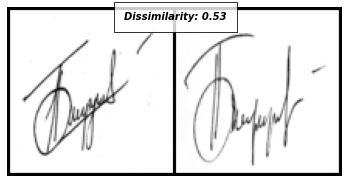

Real vs Real
Output 1: tensor([[0.7022, 1.4496]], device='cuda:0', grad_fn=<AddmmBackward0>) 
 Output 2: tensor([[0.9037, 0.6770]], device='cuda:0', grad_fn=<AddmmBackward0>)
0.8884631395339966
Actual Label:- Forged Pair Of Signature


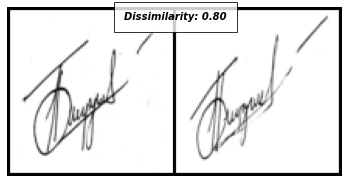

In [ ]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    


def test_siamese(img_path_1, img_path_2):
  preprocessing = transforms.Compose([transforms.Resize((105,105)), transforms.ToTensor()])
  img1 = Image.open(img_path_1)
  img2 = Image.open(img_path_2)
  img1 = preprocessing(img1.convert("L")).unsqueeze(0)
  img2 = preprocessing(img2.convert("L")).unsqueeze(0)
  concatenated = torch.cat((img1,img2))

  output1,output2 = model(img1.to(device),img2.to(device))
  print(f"Output 1: {output1} \n Output 2: {output2}")
  eucledian_distance = nn.functional.pairwise_distance(output1, output2)
  # print(f"Euclidian distance {eucledian_distance.item()}")
  cosine = compare_embeddings(output1,output2)
  print(cosine.item())
  if eucledian_distance.item() <= 0.5:
      label = "Original Pair Of Signature"
  else:
      label = "Forged Pair Of Signature"
  print("Actual Label:-", label)

  imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(eucledian_distance.item()))


real_1_path = "/content/drive/MyDrive/WhoSigned/my_signatures/real_1.jpg"
real_2_path = "/content/drive/MyDrive/WhoSigned/my_signatures/real_2.jpg"
fake_1_path = "/content/drive/MyDrive/WhoSigned/my_signatures/fake_1.jpg"

print('Real vs Fake')
test_siamese(real_1_path, fake_1_path)
print("="*60)
print('Real vs Real')

test_siamese(real_1_path, real_2_path)

# Database (SQLite)

In [ ]:
"""
Datbase
"""

import sqlite3
import pickle


class MetaSingleton(type):
  """
  Class represents Sinfleton-pattern for database
  """
  _instances = {}

  def __call__(cls, *args, **kwargs):
      if cls not in cls._instances:
          cls._instances[cls] = super(MetaSingleton, cls).__call__(*args, **kwargs)
      return cls._instances[cls]


class Database(metaclass=MetaSingleton):
  """
  Class represents database
  """
  def __init__(self, path=""):
    """
    Initilization of database
    :param path: absolute path without filename to database(default ="")
    """
    db_filepath = path + "signatures.db"

    if not os.path.exists(db_filepath):
      open(db_filepath, 'a').close()

    if path == "":
        self.conn = sqlite3.connect(db_filepath, check_same_thread=False)
    else:
        self.conn = sqlite3.connect(db_filepath, check_same_thread=False)

    self.cur = self.conn.cursor()
    self.cur.execute("DROP TABLE IF EXISTS signatures;")
    self.cur.execute('''CREATE TABLE IF NOT EXISTS signatures
        (id INTEGER PRIMARY KEY NOT NULL,
        uid BIG INT,
        sign BLOB);''')
    self.conn.commit()

  def insert_sign(self, sign, uid):
    """
    Method implements inserting sign and uid to database
    :param sign: embedding of signature photo
    :param uid: uid of sender in telegram to insert in database
    """
    try:
        sqlite_insert_query = 'INSERT INTO signatures(sign, uid) VALUES (?, ?)'
        self.cur.execute(sqlite_insert_query, (sqlite3.Binary(pickle.dumps(sign)), uid))
        self.conn.commit()
        return uid
    except sqlite3.Error as error:
        print("Error while working with SQLite", error)

  def check_signs(self, sign):
    """
    Method implements checking if sign exists in database
    :param sign: embedding of signature photo to check
    """
    try:
        sqlite_select_query = 'SELECT uid FROM signatures WHERE sign == ?'
        answer = self.cur.execute(sqlite_select_query,
                                  (sqlite3.Binary(pickle.dumps(sign)),)).fetchone()
        if answer is None:
            return None
        else:
            return answer[0]
    except sqlite3.Error as error:
        print("Error while working with SQLite", error)

  def get_sign_by_id(self, id):
    """
    Method implements getting information from database by id
    :param id: id to fetch from database
    """
    try:
        sqlite_select_query = 'SELECT sign FROM signatures WHERE id == ?'
        answer = self.cur.execute(sqlite_select_query, (id,)).fetchone()
        if answer is None:
            return []
        else:
            return pickle.loads(answer[0])
    except sqlite3.Error as error:
        print("Error while working with SQLite", error)

  def get_sign_by_uid(self, uid):
    """
    Method implements getting information from database by uid
    :param uid:uid to fetch from database
    """
    try:
        sqlite_select_query = 'SELECT sign FROM signatures WHERE uid == ?'
        answer = self.cur.execute(sqlite_select_query, (uid,)).fetchone()
        if answer is None:
            return []
        else:
            return pickle.loads(answer[0])
    except sqlite3.Error as error:
        print("Error while working with SQLite", error)

  def delete_sign_by_uid(self, sign):
    """
    Method implements deleting information from database by uid
    :param sign: sign uid to delete from database
    """
    try:
        sqlite_delete_query = 'DELETE FROM signatures WHERE uid = ?'
        self.cur.execute(sqlite_delete_query, (sign,))
    except sqlite3.Error as error:
        print("Error while working with SQLite", error)

  def delete_sign_by_id(self, id):
    """
    Method implements deleting information from database by id
    :param id: id to delete from database
    """
    try:
        sqlite_delete_query = 'DELETE FROM signatures WHERE id = ?'
        self.cur.execute(sqlite_delete_query, (id,))
    except sqlite3.Error as error:
        print("Error while working with SQLite", error)

  def __del__(self):
    """
    Destructor of database class
    """
    self.cur.close()
    self.conn.close()
    print('Connection closed')


# Bot


In [ ]:
path = "/content/drive/MyDrive/photos"
# Check if file exists
if os.path.isfile(path):
  os.mkdir(path)

In [ ]:

"""
Bot
"""
import requests
from PIL import Image


class Bot:
    """
    Class represents telegram bot
    """
    def __init__(self, token, server_url):
        """
        Initilization of bot
        :param token: bot'token from @BotFather
        :param server_url: utl to set webhook
        """
        self.token = token
        self.server_url = server_url
        self.set_webhook()

    def make_api_url(self, method):
        """
        Method to create API url to telegram
        :param method: bot's method
        :return: string url
        """
        return f"https://api.telegram.org/bot{self.token}/{method}"

    def set_webhook(self):
        """
        Method to set webhook
        :return: response in JSON
        """
        method = "setWebhook"
        api_url = self.make_api_url(method)
        post_data = {
            "url": self.server_url,
        }
        req = requests.post(api_url, data=post_data, headers={'header': 'Content-Type: application/json'})
        return req.json()

    def send_message(self, chat_id, text):
        """
        Send message to tg user with text
        :param chat_id: user/group to send message
        :param text:  to send
        """
        method = "sendMessage"
        url = self.make_api_url(method)
        data = {"chat_id": chat_id, "text": text}
        requests.post(url, data=data)

    def get_photo_path(self, photo_id):
        """
        Method to get photo path by photo id
        :param photo_id: of user's photo
        :return: photo_path
        """
        method = "getFile"
        api_url = self.make_api_url(method)
        post_data = {
            'file_id': photo_id,
            "url": self.server_url
        }
        req = requests.post(api_url, data=post_data, headers={'header': 'Content-Type: application/json'})
        return req.json()['result']['file_path']

    def get_photo(self, photo_id):
        """
        Method to  get photo with telegram api
        :param photo_id:  of user's photo
        :return: photo_path, opens requested image
        """
        photo_path = self.get_photo_path(photo_id)
        photo_url = f'https://api.telegram.org/file/bot{self.token}/{photo_path}'
        return photo_path, Image.open(requests.get(photo_url, stream=True).raw)

In [ ]:
port = 5000

ngrok_token = os.getenv('NGROK_TOKEN')

#Setting an auth token allows us to open multiple tunnels at the same time
ngrok.set_auth_token(ngrok_token)

# Open a ngrok tunnel to the HTTP server
public_url = ngrok.connect(port).public_url
print(" * ngrok tunnel \"{}\" -> \"http://127.0.0.1:{}\"".format(public_url, port))

 * ngrok tunnel "http://44a9-35-245-32-41.ngrok.io" -> "http://127.0.0.1:5000"


In [ ]:
app = Flask(__name__)

# Update any base URLs to use the public ngrok URL
app.config["BASE_URL"] = "https" + public_url.split('http')[1]
print(app.config["BASE_URL"])

token = os.getenv('BOT_TOKEN')
bot = Bot(token, app.config["BASE_URL"])

drive_dir = '/content/drive/MyDrive/'

approve_clients = []


db = Database()


def download_photo(bot, message, download_path=None):
    if "photo" in message:
      photo_path, downloaded_photo = bot.get_photo(message["photo"][0]['file_id'])
    elif "document" in message:
      photo_path, downloaded_photo = bot.get_photo(message["document"]["thumb"]['file_id'])
      photo_path = "photos" + photo_path.split("thumbnails")[1]
    else:
      return ""
    if download_path is None:
      download_path = drive_dir + photo_path
    downloaded_photo.save(download_path)
    return download_path

@app.route("/", methods=["GET", "POST"])
def receive_update():
  if request.method == "POST":
      print(request.json)
      message = request.json["message"]
      chat_id = message["chat"]["id"]
      photos = message.get("photo")
      uid = message["from"]["id"]

      # /my_sign + photo - functionality
      if ("caption_entities" in message and message["caption"] == "/my_sign" and message["caption_entities"][0]["type"] == "bot_command" and 
          ("photo" in message) or ("document" in message and message["document"]["mime_type"].split("/")[0] == "image") ) or (uid  in approve_clients):

        # сохранить фото
        dpath = download_photo(bot, message, drive_dir + "photos/" + str(uid) + ".jpg")

        # посмотреть, если uid уже есть в бд
        # если есть, то:
        if (uid not in approve_clients) and (db.get_sign_by_uid(uid) != []):
          bot.send_message(chat_id, "Do you want to change your signature? (yes/no)")
          approve_clients.append(uid)

        else:
        # проверяем если ответ нет, то:
          if "text" in message and message["text"] == "no" and uid in approve_clients:
            approve_clients.remove(uid)
            dpath = drive_dir + "photos/" + str(uid) + ".jpg"
            os.remove(dpath)
            bot.send_message(chat_id, "Ok")
        #если да или это новый пользователь, то добавляем    
          elif ("text" in message and message["text"] == "yes") or db.get_sign_by_uid(uid)== []:
            if db.get_sign_by_uid(uid)!= [] :
              db.delete_sign_by_uid(uid)
              approve_clients.remove(uid)
              dpath = drive_dir + "photos/" + str(uid) + ".jpg"

            # сделать embedding
            embedding = create_embedding(dpath)

            # занести под uid embedding в бд
            db.insert_sign(embedding, uid)

            # удалить фото
            os.remove(dpath)
            bot.send_message(chat_id, "Success! Now you can verify signature")

      #тоже решил объединить все виды фоточек
      elif ("photo" in message) or ("document" in message and message["document"]["mime_type"].split("/")[0] == "image"):
        if (db.get_sign_by_uid(uid) == []):
            bot.send_message(chat_id, "Oof, can you send photo/scan of your signature with caption - /my_sign ?")
        else:

          dpath = download_photo(bot, message)

          res = predict(dpath)
          print(res)
          
          #compare embeddings
          embedding = create_embedding(dpath)
          print(embedding, db.get_sign_by_uid(uid))
          print(compare_embeddings(embedding, db.get_sign_by_uid(uid)))

          # Delete photo after processing
          os.remove(dpath)

          bot.send_message(chat_id, res)

      # Start command
      elif "entities" in message and message["text"] == "/start" and message["entities"][0]["type"] == "bot_command":
          bot.send_message(chat_id, "Hello, %s! Can you send me scan of your signature?" % (message["from"]["first_name"]))
      # Otherwise
      else:
          bot.send_message(chat_id, "It's not a photo of signature")

  return message

# Start the Flask server in a new thread
# threading.Thread(target=app.run, kwargs={"use_reloader": False}).start()

https://44a9-35-245-32-41.ngrok.io


In [ ]:
app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


{'update_id': 170344936, 'message': {'message_id': 446, 'from': {'id': 376088940, 'is_bot': False, 'first_name': 'Borya', 'username': 'boryapatrushev', 'language_code': 'en'}, 'chat': {'id': 376088940, 'first_name': 'Borya', 'username': 'boryapatrushev', 'type': 'private'}, 'date': 1644042697, 'photo': [{'file_id': 'AgACAgIAAxkBAAIBvmH-GcnBwFnKqLvrEREkHHRJm06nAAIHtjEbdeTxS-PsJwT_HkgUAQADAgADcwADIwQ', 'file_unique_id': 'AQADB7YxG3Xk8Ut4', 'file_size': 1359, 'width': 90, 'height': 76}, {'file_id': 'AgACAgIAAxkBAAIBvmH-GcnBwFnKqLvrEREkHHRJm06nAAIHtjEbdeTxS-PsJwT_HkgUAQADAgADbQADIwQ', 'file_unique_id': 'AQADB7YxG3Xk8Uty', 'file_size': 19223, 'width': 320, 'height': 271}, {'file_id': 'AgACAgIAAxkBAAIBvmH-GcnBwFnKqLvrEREkHHRJm06nAAIHtjEbdeTxS-PsJwT_HkgUAQADAgADeAADIwQ', 'file_unique_id': 'AQADB7YxG3Xk8Ut9', 'file_size': 25251, 'width': 440, 'height': 372}]}}


127.0.0.1 - - [05/Feb/2022 06:31:37] "POST / HTTP/1.1" 200 -


{'update_id': 170344937, 'message': {'message_id': 448, 'from': {'id': 376088940, 'is_bot': False, 'first_name': 'Borya', 'username': 'boryapatrushev', 'language_code': 'en'}, 'chat': {'id': 376088940, 'first_name': 'Borya', 'username': 'boryapatrushev', 'type': 'private'}, 'date': 1644042723, 'photo': [{'file_id': 'AgACAgIAAxkBAAIBwGH-GePhxfgNSt7FA61B6RgjLQyXAAIHtjEbdeTxS-PsJwT_HkgUAQADAgADcwADIwQ', 'file_unique_id': 'AQADB7YxG3Xk8Ut4', 'file_size': 1359, 'width': 90, 'height': 76}, {'file_id': 'AgACAgIAAxkBAAIBwGH-GePhxfgNSt7FA61B6RgjLQyXAAIHtjEbdeTxS-PsJwT_HkgUAQADAgADbQADIwQ', 'file_unique_id': 'AQADB7YxG3Xk8Uty', 'file_size': 19223, 'width': 320, 'height': 271}, {'file_id': 'AgACAgIAAxkBAAIBwGH-GePhxfgNSt7FA61B6RgjLQyXAAIHtjEbdeTxS-PsJwT_HkgUAQADAgADeAADIwQ', 'file_unique_id': 'AQADB7YxG3Xk8Ut9', 'file_size': 25251, 'width': 440, 'height': 372}], 'caption': '/my_sign', 'caption_entities': [{'offset': 0, 'length': 8, 'type': 'bot_command'}]}}


127.0.0.1 - - [05/Feb/2022 06:32:04] "POST / HTTP/1.1" 200 -


In [ ]:
!pip install pipreqsnb
!pipreqsnb --force


  Created wheel for pipreqsnb: filename=pipreqsnb-0.2.4-py3-none-any.whl size=4142 sha256=6cf42e4cf5d425c0cfeb02267e67f4d800e9b2d8db6edd543eb7e4ac947ee201
  Stored in directory: /root/.cache/pip/wheels/23/7f/59/7a87faea552278c8ef0c171ea4d27494eb91ac9380567239b6
Successfully built pipreqsnb
Exception occurred while working on file /content/drive/MyDrive/Colab Notebooks/Untitled1.ipynb, cell 3/26
Traceback (most recent call last):
  File "/usr/local/bin/pipreqsnb", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.7/dist-packages/pipreqsnb/pipreqsnb.py", line 130, in main
    raise e
  File "/usr/local/lib/python3.7/dist-packages/pipreqsnb/pipreqsnb.py", line 126, in main
    imports += get_import_string_from_source(source)
  File "/usr/local/lib/python3.7/dist-packages/pipreqsnb/pipreqsnb.py", line 26, in get_import_string_from_source
    tree = ast.parse(source)
  File "/usr/lib/python3.7/ast.py", line 35, in parse
    return compile(source, filename, mode, PyCF_O